# Exercise 6 :
# Lennard-Jones particles and Velocity Verlet integrator

* Léa Beaules
* 15 December 2020

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import random
import copy
import numpy as np
import scipy as scy
from tqdm.notebook import trange, tqdm
import time 
from scipy.stats import maxwell

#used for the video
import subprocess
import glob
import os

## Task I: Implementation of Berendsen thermostat

**Berendsen thermostat** (velocity rescaling factor) \
Later set to T = 300 K with τ = 0.2 ps.

$$ \lambda = \sqrt{1+ \frac{\Delta t}{\tau}(\frac{T_{0}}{T}-1)} $$



In [2]:
def Lambda_fact(Dlt_t, tau, Temp_o, Temp):
    lambda_f = np.sqrt( 1 + (Dlt_t/tau)*(Temp_o/Temp -1))
    return lambda_f

**Maxwell Boltzmann distribution** with a scale parameter $a= \sqrt{\frac{k_{b}T}{m}}$

In [3]:
def MaxBoltz ():
    a = np.sqrt(k_b * Temp_ini / mass)
    mx = maxwell(scale=a)     
    x = np.linspace(mx.ppf(0.01),mx.ppf(0.99), 100)
    velocity_distribution  = mx.rvs(size=1000)
    return a, velocity_distribution

## Task II: Force autocorrelation and friction coefficient calculation

## Task III : Simulation

Simulation of 49 particules in a 5x5nm box (with PBC).  \
The interparticle interaction is modeled as a Lennard-Jones potential. \
The Velocity Verlet integrator is used to calculate the motion of the particles.
The following constant are used :

In [4]:
box = (5,5)#nm²

#20000 total time steps in the simulation
steps = 100

#Number of particles in the box
Particule_Nbr = 49
mass = 18 #g/mol

#Time step (2*e-6 in nm)
Dlt_t = 2e-6 #ns = 2fs
tau = 2e-4 #ns = 0.2ps

k_b = 8.314462 #J⋅K^(-1).mol^(-1)
Temp_o = 300 #K

#Temperature used for the initial Maxwell-Boltzmann velocity distribution
Temp_ini = 100 #K

#Constant used in the Lennard Jones potential
C_12 = 9.847044 *10**(-6) #kJ mol^-1 nm^12
C_6  = 6.2647225 *10**(-3) #kJ mol^-1 nm^6

**Position**

$x_{k+1} = x_{k} + v_{k} \Delta t + \frac{1}{2}a_{k} \Delta t^{2}$

In [5]:
def position (x_k, v_k, a_k, Dlt_t):
    x_k1 = x_k + v_k*Dlt_t + (1/2)*a_k*(Dlt_t**2)
    return x_k1

**Velocity**

$v_{k+1} = v_{k} + \frac{1}{2}( a_{k} + a_{k+1} ) \Delta t$

Maybe the units are wrong and my acceleration difference isso smallthat is does not affect my velocity

In [6]:
def velocity (v_k, a_k, a_k1, Dlt_t):
    v_k1 = v_k + (1/2)*(a_k+a_k1)*Dlt_t
    return v_k1

**Potential** (Lennard Jones)

$V_{IJ}(r_{ij}) = \frac{C_{12}}{r_{ij}^{12}}-\frac{C_{6}}{r_{ij}^{6}}$

In [7]:
def potential(r_ij_vect):
    #distance between the two particules 
    r_ij = np.sqrt(r_ij_vect[0]**2 + r_ij_vect[1]**2)
    
    if r_ij == 0:
        return 0
    else :
        V_ij = C_12/r_ij**(12) - C_6/r_ij**(6)
        return V_ij

In [8]:
def pot_total(time_t):
    V= 0 
    
    for our_p_ind in range (Particule_Nbr):
        our_p = Particules_list[our_p_ind]
        for other_p_ind in range(our_p_ind+1 ,Particule_Nbr) :
            other_p = Particules_list[other_p_ind]

            r_ij_vect = get_vect_r(our_p,other_p)
            V += potential(r_ij_vect)
            
    return V

In [9]:
def pot_total_BIS(Relative_dist_arrays_X, Relative_dist_arrays_Y, t):
    V= 0 
    
    for p_ind in range (Particule_Nbr):
        #list of relative distances along x and y with all the other particles at time t
        r_vectx = Relative_dist_arrays_X[t][p_ind,:] 
        r_vecty = Relative_dist_arrays_Y[t][p_ind,:]

        #Calculating the total potential on (p_ind)th particle
        for i in range (len(r_vectx)):
            V += potential([r_vectx[i],r_vecty[i]])
           
    return V

**Force / acceleration**

$f (t) = mẍ (t) = mv̇ (t) = ma(t)$

Mybe I should instead but over all the particule at the end of a step, to get all the relatic=ve distances and calculate all the forces

* Calculating the vector r, using the particle class

In [10]:
def get_vect_r(particul1, particul2): 
    x_list =[]
    x_list += [particul2.x - particul1.x]
    x_list += [particul2.x - particul1.x + box[0]]
    x_list += [particul2.x - particul1.x - box[0]]
    x_part = min(x_list, key=abs)
    
    y_list =[]
    y_list += [particul2.y - particul1.y]
    y_list += [particul2.y - particul1.y + box[1]]
    y_list += [particul2.y - particul1.y - box[1]]
    y_part = min(y_list, key=abs)
    
    r = [x_part, y_part]
    
    return r

* Calculating the vector r with the x and y values of the two particles

In [11]:
def get_vect_r_BIS(x,y, x2, y2): 
    x_list =[]
    x_list += [x2 - x]
    x_list += [x2 - x + box[0]]
    x_list += [x2 - x - box[0]]
    x_part = min(x_list, key=abs)
    
    y_list =[]
    y_list += [y2 - y]
    y_list += [y2 - y + box[1]]
    y_list += [y2 - y - box[1]]
    y_part = min(y_list, key=abs)
    
    r = [x_part, y_part]
    
    return r

In [12]:
def force_ij(r_ij_vect):
    #distance between the two particules 
    r_ij = np.sqrt(r_ij_vect[0]**2 + r_ij_vect[1]**2)
    
    if r_ij != 0: 
        factor = (12*C_12/r_ij**(13) - 6*C_6/r_ij**(7))/r_ij
        Fij_x = factor * r_ij_vect[0]
        Fij_y = factor * r_ij_vect[1]
        
        Fij_vect = [Fij_x, Fij_y]
        return Fij_vect
    
    else :
        return [0,0]
    
    

Calculating the for on the (p_ind)th particle using the Relative_dist_arrays 

In [13]:
def force_BIS(Relative_dist_arrays_X, Relative_dist_arrays_Y,t , p_ind):
    F= [0,0] #total force vector acting on our particle
    if t > (steps-1):
        return F[0,0]
    
    #list of relative distances along x and y with all the other particles
    r_vectx = Relative_dist_arrays_X[t][p_ind,:] 
    r_vecty = Relative_dist_arrays_Y[t][p_ind,:]
    
    #Calculating the total force on (p_ind)th particle
    for i in range (len(r_vectx)):
        Fij_vect = force_ij([r_vectx[i],r_vecty[i]])
        
        #sum
        F[0] += Fij_vect[0]
        F[1] += Fij_vect[1]
        
    return F

Maybe using this calculation of the force, the force vector for a specific particle, with p_ind th (indice), if does not use the force function but should not make much difference in running time.

In [14]:
def force_TER(Relative_dist_arrays_X, Relative_dist_arrays_Y,t, p_ind):
    F= [0,0] #total force vector acting on our particle
    if t > (steps-1):
        return F[0,0]
    
    #list of relative distances along x and y with all the other particles
    #indice in r_vectx/y corespond to the indice of the particle
    r_vectx = Relative_dist_arrays_X[t][p_ind,:] 
    r_vecty = Relative_dist_arrays_Y[t][p_ind,:]
    
    #r_vect_tot list all the norme of the relative distances
    r_vect_tot =[np.sqrt(r_vectx[i]**2 + r_vecty[i]**2) for i in range (len(r_vectx))]

    #looping over the the relative distances between our particle and all the other.
    particle_ind = 0
    Fij_x, Fij_y = 0,0
    for r_ij in r_vect_tot:
        if r_ij != 0 :
            factor = (12*C_12/r_ij**(13) - 6*C_6/r_ij**(7))/r_ij
            Fij_x += factor * r_vectx[particle_ind]
            Fij_y += factor * r_vectY[particle_ind]
        particle_ind += 1

    #total force vector
    return [Fij_x,Fij_y]

Original calculation of the force looping over all the particles distances

In [15]:
def force (our_p_ind):
    F= [0,0] #total force vector acting on our particle
    our_p = Particules_list[our_p_ind]
    
    for other_p_ind in range(Particule_Nbr) :
        if other_p_ind != our_p_ind:
            other_p = Particules_list[other_p_ind]
            
            r_ij_vect = get_vect_r(our_p,other_p)
            Fij_vect = force_ij(r_ij_vect)
            
            F[0] += Fij_vect[0]
            F[1] += Fij_vect[1]
    return F

**Kinetic energy**

$E_{kin} = \frac{1}{2} m <v^{2}>$

In [16]:
def Kinetic(Data_traj_list, time_t):
    K_list = []
    for p_ind in range (Particule_Nbr):
        p_vx = Data_traj_list[p_ind][2,time_t]
        p_vy = Data_traj_list[p_ind][3,time_t]
        v = np.sqrt(p_vx**2 + p_vy**2)
        K_list += [v**2]
    K = (1/2)*mass*np.mean(K_list)
    #print(time_t, v)
    return K

**Initialisation**

* Check that the force function looks correct :

There is a strong repulsive force if a particle gets closer then  0.4347826086956522 nm


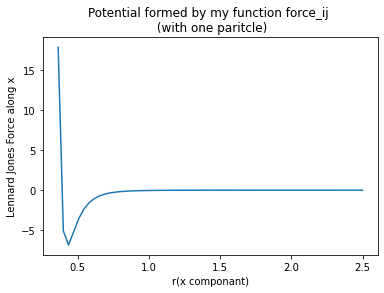

In [17]:
a = np.linspace(0,2.5, 70)
f =[]
for i in range (70):
    f += [force_ij([a[i],0])[0]]

plt.plot(a[10:],f[10:])
plt.title('Potential formed by my function force_ij \n (with one paritcle)')
plt.ylabel('Lennard Jones Force along x')
u = plt.xlabel('r(x componant)')
mi = f.index(min(f)) #index of the minimum
print('There is a strong repulsive force if a particle gets closer then ', a[mi], 'nm')

### Relative distance between the particles

Creating a gereral list of arrays, with one array per time steps storing the relative distance of the particles. With $r_{ij}$ being the vector r from particle i to particle j :


$$\begin{pmatrix} r_{11}=0 & r_{12}  & \dots & r_{1N} \\ 
r_{21} & r_{22}=0 & \dots & r_{2N}\\ 
\dots &\dots  &\ddots &\dots \\
r_{N1} & r_{N2} &  \dots & r_{NN}=0\end{pmatrix}_{t}$$


From the data traj list information it calculates the relative distance between all the particles of the system at the time t given in argument. And updates the gereral Relative_distance_arrays, adding the new arrays for time t

-Takes a bit of time to run-

In [18]:
def Relative_dist(Relative_dist_arrays_X, Relative_dist_arrays_Y, t):

    Relative_dist_arrays_X += [np.zeros((Particule_Nbr,Particule_Nbr))]
    Relative_dist_arrays_Y += [np.zeros((Particule_Nbr,Particule_Nbr))]

    for p in range (Particule_Nbr):
        xp= Data_traj_list[p][0,:]
        yp= Data_traj_list[p][1,:]

        for p2 in range (p+1,Particule_Nbr):
            xp2 = Data_traj_list[p2][0,:]
            yp2 = Data_traj_list[p2][1,:]  

            #vector r from particle p to particle p2
            r_vector = get_vect_r_BIS(xp[t],yp[t], xp2[t], yp2[t]) 
            Relative_dist_arrays_X[t][p,p2] = r_vector[0]
            Relative_dist_arrays_Y[t][p,p2] = r_vector[1]

            #opposite vector r from p2 to p
            Relative_dist_arrays_X[t][p2,p] = -r_vector[0]
            Relative_dist_arrays_Y[t][p2,p] = -r_vector[1]
            
    return (Relative_dist_arrays_X, Relative_dist_arrays_Y)


    #i_lower = np.tril_indices(n, -1)
    #matrix[i_lower] = matrix.T[i_lower]

**Initialise simulation** 

The particles are placed on a regular grid of 7x7 particles. They are assigned their initial velocity $|v(x,y)|$ following the Maxwell-Boltzmann distribution at $T=100K$, with random directions. 

In [19]:
class Particle:
    def __init__(self, x, y, vx, vy, ax, ay):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.ax = ax
        self.ay = ay
        
    def __repr__(self):
        return str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.x,self.y,self.vx,self.vy))

In [20]:
def Particules_initialise (Particule_Nbr, steps):
    Particules_list = []
    Data_traj_list = []
    a, velocity_distribution = MaxBoltz()

    
    #regurlar grid 7*7
    nx, ny = (7, 7)
    x_grid = np.linspace(0, 5, nx+1)
    y_grid = np.linspace(0, 5, ny+1)
    
    d = x_grid[2]-x_grid[1]
    
    x_grid = x_grid[0:len(x_grid)-1] +d/2
    y_grid = y_grid[0:len(y_grid)-1] +d/2
    
    
    print('The space between two particle is : ', d, 'nm')

    p_count = 0
    for i in range (nx):
        for j in range (ny) :
            #Initial position on a uniform grid
            angle = np.random.uniform(0,2*np.pi)
            x_p = x_grid[i]
            y_p = y_grid[j]
            
            #Initial velocities : Maxwell-Boltzmann distribution with random direction
            vel = velocity_distribution[np.random.randint(0, len(velocity_distribution))]
            vx_p = np.sin(angle)*vel
            vy_p = np.cos(angle)*vel
            Particules_list += [Particle(x_p, y_p, vx_p, vy_p, 0, 0)]
            Data_traj_list += [np.zeros((4,steps))]
            
            Data_traj_list[p_count][:,0] = [x_p, y_p, vx_p, vy_p] #[particle indice][data type, time step]
            
            p_count += 1
    print('Number of particles = ', p_count)
    return Particules_list, Data_traj_list

In [21]:
Particules_list, Data_traj_list = Particules_initialise (Particule_Nbr, steps)

The space between two particle is :  0.7142857142857143 nm
Number of particles =  49


**Run Simulation**

At the start of the simulation we already have the initial positions, velocities and acceleration/force calculated. At each step we calculate : \
FIRST LOOP :
* Position at time t+1

Calculate all the relative distance at time t+1

SECOND LOOP :
* Force at time t+1
* Velocities at time t+1

END OF TIME STEP
* Rescaling the velocities with Berendsen thermostat

In [22]:
#arrays of relative distance between the particles
Relative_dist_arrays_X = []
Relative_dist_arrays_Y = []
Potential_list = [0]*steps

# At time = 0
Relative_dist_arrays_X, Relative_dist_arrays_Y = Relative_dist(Relative_dist_arrays_X, Relative_dist_arrays_Y, 0)
Potential_list[0] = pot_total_BIS(Relative_dist_arrays_X, Relative_dist_arrays_Y, 0)

for i in trange (steps-1):    
    for p_ind in range (Particule_Nbr):
        our_P = Particules_list[p_ind]
        # calculating the next position
        x_1 = position (our_P.x, our_P.vx , our_P.ax, Dlt_t)%box[0]
        y_1 = position (our_P.y, our_P.vy, our_P.ay, Dlt_t)%box[1]
        # updating the particule position
        our_P.x = x_1
        our_P.y = y_1
        Data_traj_list[p_ind][0,i+1] = x_1
        Data_traj_list[p_ind][1,i+1] = y_1     
        
    # Calculating the relative distance between all the particles at time i+1 ---> the one that takes the most time !
    Relative_dist_arrays_X, Relative_dist_arrays_Y = Relative_dist(Relative_dist_arrays_X, Relative_dist_arrays_Y, i+1)
    Potential_list[i+1] = pot_total_BIS(Relative_dist_arrays_X, Relative_dist_arrays_Y, i+1)
    
    for ind in range (Particule_Nbr):
        our_P = Particules_list[ind]
        
        # calculating the force/acceleration at the next step
        F_1 = force_BIS (Relative_dist_arrays_X, Relative_dist_arrays_Y,i+1 ,ind)
        ax_1, ay_1 = -F_1[0]*1/(mass*1), -F_1[1]*1/(mass*1)
        
        #velocity 
        vx_1 = velocity (our_P.vx, our_P.ax, ax_1, Dlt_t)
        vy_1 = velocity (our_P.vy, our_P.ay, ay_1, Dlt_t)

        #updating velocity and acceleration 
        our_P.ax = ax_1
        our_P.ay = ay_1
        our_P.vx = vx_1
        our_P.vy = vy_1
        Data_traj_list[ind][2,i+1] = vx_1
        Data_traj_list[ind][3,i+1] = vy_1
    
    #rescaling the velocities
    K = Kinetic(Data_traj_list, i+1)
    Temp = K / k_b
    lbda = Lambda_fact(Dlt_t, tau, Temp_o, Temp)
    for ind in range(Particule_Nbr):
        Rs_vx = (Data_traj_list[ind][2,i+1]) * lbda
        Rs_vy = (Data_traj_list[ind][3,i+1]) * lbda
        P = Particules_list[ind]
        
        P.vx, Data_traj_list[ind][2,i+1] = Rs_vx, Rs_vx
        P.vy, Data_traj_list[ind][3,i+1] = Rs_vy, Rs_vy
        
    

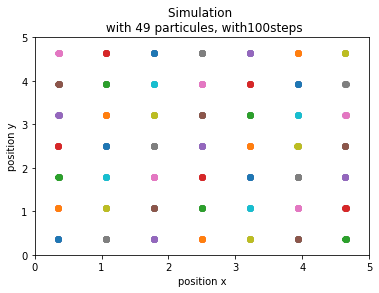

In [40]:
for i in trange(1,desc= 'Plot the graph of the last simulation'):

    #def plot_simulation (Particule_Nbr, Data_traj_list, Particules_list):
    for parti in range (Particule_Nbr):
        data_traj = Data_traj_list[parti]
        #Particule = Particules_list[parti]
        plt.plot(data_traj[0,:],data_traj[1,:], marker='.', markersize='10',  linestyle = '-')   
        
    plt.xlabel('position x')
    plt.ylabel('position y')
    plt.xlim(0,5)
    plt.ylim(0,5)

    Titles_graph1 = 'Simulation \n with ' + str(Particule_Nbr)+ ' particules, and' + str(steps) + 'steps'
    plt.title(Titles_graph1)

* Analyse the force of the first particles coliding

In [24]:
np.savez('save.npz', Data_traj_list, Potential_list, Relative_dist_arrays_X, Relative_dist_arrays_Y)

In [25]:
#npzfile = np.load('save_array5.npz')
#Data_traj_list = npzfile['arr_0']
#Potential_list = npzfile['arr_1']

### Video

In [33]:
def creat_files():
    os.chdir("Image_storing_video")

    #def plot_simulation (Particule_Nbr, Data_traj_list, Particules_list):
    for t in trange (int(8)) :
        for parti in range (Particule_Nbr):
            data_traj = Data_traj_list[parti]
            plt.plot(data_traj[0,t],data_traj[1,t], marker='.', markersize='10',  linestyle = '-', color = 'black')

            plt.xlabel('position x')
            plt.ylabel('position y')
            plt.xlim(0,box[0])
            plt.ylim(0,box[1])
        plt.savefig("File%02d.png" % t)
        #plt.show()
        #plt.savefig("file.png")
        plt.close()



    Titles_graph1 = 'Example of one of the simulation of ' + str(Particule_Nbr)+ ' particules, with' + str(steps) + 'steps'
    plt.title(Titles_graph1)
    os.chdir("../")

In [34]:
def creat_video():
    os.chdir("Image_storing_video")
    
    subprocess.call(['ffmpeg', '-framerate', '8', '-i', 'File%02d.png', '-r', '30', '-pix_fmt', 'yuv420p', 'Contagion04.mp4'])
    #subprocess.call(['ffmpeg', '-framerate', '8', '-i', Titles_files, '-r', '30', '-pix_fmt', 'yuv420p', Filename])

    
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

    os.chdir("../")

Current working directory /home/lea/Bureau/Fac/Master/Simulating_the_physical_world/Simulations/ThermoACF


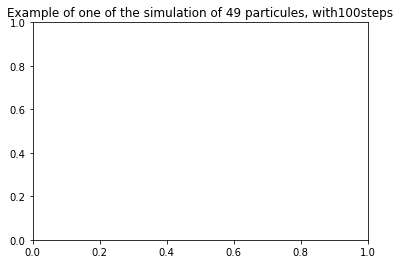

In [36]:
#os.chdir("ThermoACF")
retval = os.getcwd()
print ("Current working directory %s" % retval)
creat_files()
creat_video()

## Task III : Potential and Kinetic energy

In [ ]:
time_list = np.linspace(0,steps/2,steps)

**Total potential energy (per step)**

Calculating the potential using the relative distance arrays

In [ ]:

from scipy.linalg import sqrtm
def pot (t):
    # All the other particles relative distances with the p_ind th particle at time t
    r_vector_x = Relative_dist_arrays_X[t]
    r_vector_y = Relative_dist_arrays_Y[t]

    #Calculating the distance with all the other particuls (including over the borders)
    rx_sqrd = np.linalg.matrix_power(r_vector_x , 2)
    ry_sqrd = np.linalg.matrix_power(r_vector_y , 2)
    norme_sqrd = np.add(rx_sqrd, ry_sqrd)
    radial_distance_list = sqrtm(norme_sqrd) # SQUARE ROOT
    #radial_distance_list = [np.sqrt(r_vector_x[i]**2 + r_vector_y[i]**2) for i in range (len(r_vector_x))]

    RDist_12 = np.linalg.matrix_power(radial_distance_list, -12)*C_12
    RDist_6 = np.linalg.matrix_power(radial_distance_list, -6)*C_6

    pot = np.sum(np.subtract(RDist_12,RDist_6))
    
    return pot

In [ ]:
plt.plot(time_list[1:-1], Potential_list[1:-1])
#plt.title('Evolution over time of the total potential energy')
#plt.ylabel('Potential energy in J')

Kin_list = []
for i in trange (steps):
    Kin_list += [Kinetic(Data_traj_list,i)]
    
plt.plot(time_list, Kin_list)
plt.title('Evolution over time of the total kinetic energy')
plt.xlabel('Time in fs')
plt.ylabel('Kinetic energy in J')

**Total kinetic energy (per step)**

In [ ]:
Kin_list = []
for i in trange (steps):
    Kin_list += [Kinetic(Data_traj_list,i)]
plt.plot(time_list, Kin_list)
plt.title('Evolution over time of the total kinetic energy')
plt.xlabel('Time in fs')
plt.ylabel('Kinetic energy in J')

**Interpretation of the results**

## Task IV : Radial distribution function and two-particle PMF

In [ ]:
def radial_function (Data_traj_list, t):
    r_nbr = 250
    Values_r = np.linspace(0, box[0]/2, r_nbr)
    dn_allP_fixt = [0]*r_nbr
    
    for p_ind in range (Particule_Nbr):
        dn_ring_fixP_fixT = [0]*r_nbr #number of particules in the ring area in function of r
               
        # All the other particles relative distances with the p_ind th particle at time t
        r_vector_x = Relative_dist_arrays_X[t][p_ind,:]
        r_vector_y = Relative_dist_arrays_Y[t][p_ind,:]
        #removing the distance to itself 
        np.delete(r_vector_x,p_ind)
        np.delete(r_vector_y,p_ind)
        #Calculating the distance with all the other particuls (including over the borders)
        radial_distance_list = [np.sqrt(r_vector_x[i]**2 + r_vector_y[i]**2) for i in range (len(r_vector_x))]

        #count the number of particules in each ring area : Has to go tough 500*100 steps
        for x in range(len(radial_distance_list)) :
            radial_distance = radial_distance_list[x]

            for r_ind in range(r_nbr) :
                r = Values_r[r_ind]
                if radial_distance <= r :
                    dn_ring_fixP_fixT[r_ind] += 1
                    dn_allP_fixt[r_ind] += 1/(Particule_Nbr-1)

    return dn_allP_fixt

In [ ]:
def radial_function_BIS (Data_traj_list, t):
    r_nbr = 250
    Values_r = np.linspace(0, box[0]/2, r_nbr)
    Dlt_r = Values_r[1]- Values_r[0]
    
    dn_allP_fixt = [0]*r_nbr
    
    
    r_vector_x = Relative_dist_arrays_X[t]
    r_vector_y = Relative_dist_arrays_Y[t]
    
    for r_ind in range(r_nbr) :
        r = Values_r[r_ind]
        
        #first e look at the values of the 
        rx = np.where((r_vector_x > r*np.sqrt(2)/2 )&(r_vector_x <= r + Dlt_r))
        ry = np.where((r_vector_y <= r*np.sqrt(2)/2 )&(r_vector_y <= r + Dlt_r))
        
        indicesx = list(zip(rx[0], rx[1]))
        indicesy = list(zip(ry[0], ry[1]))
        
        index_list = indicesx + list(set(indicesy) - set(indicesx))
        #n_t = [0]*Particule_Nbr
                 
                      
        for i in index_list :              
            x = r_vector_x[i[0],i[1]]
            y = r_vector_y[i[0],i[1]]

            r_norm = np.sqrt(x**2 + y**2)

            if r < r_norm <= (r + Dlt_r):
                #number of particle in the ring r - r+Dltr (indice indicates the particle we are looking at)
                # fixed t and r
                #n_t[i[0]] += 1 
                dn_allP_fixt[r_ind] += 1/(Particule_Nbr-1) #same but avergaged over all the particles

    

    return dn_allP_fixt

In [ ]:
a = np.array([[1,4,19],[2,7,2]])
r = np.where(a<8)
r_p = list(zip(r[0], r[1]))
#r_other_p = list(zip(r[0], r[1]))

a = np.array([[1,4,19],[2,8,2]])
r2 = np.where(a<5)
r2_p = list(zip(r2[0], r2[1]))
#r2_other_p = list(zip(r2[0], r2[1]))

n_t = [0]*3
for i in r_p :
    if (ind_tuple in r2_p) == True :
        x =  a[i[0],i[1]]
        y = a[i[0],i[1]]
        
        r_norm = np.sqrt(x**2 + y**2)
        print (r_norm)
        if r_norm <= 3:
            n_t[i[0]] += 1

print(r_p)
print(r2_p)

The following cell is the one taking the majority of the running time (ca. 3h for 5000steps)

In [ ]:
dn_total = [0]*steps
for t in trange(steps):
    dn_allP_fixT = radial_function (Data_traj_list, t)
    for dn_ind in range(len(dn_allP_fixT)):
        dn = dn_allP_fixT[dn_ind]
        dn_total[dn_ind] += dn/steps

In [ ]:
print(dn_allP_fixT)

In [ ]:
plt.plot(np.linspace(0, box[0]/2, len(dn_total)), dn_total)

**Radial distribution function g(n)**

Calculate and display the time- and particle-averaged 2D RDF :

$$ g(n) = \frac{1}{2 \pi r \rho}\frac{dn(r)}{dr} $$

$dn(r)$ being here the difference bewteen two adjacent values in out dn list and $dr = \Delta r = 0.01$

In [ ]:
Values_r = np.linspace(0, box[0]/2, len(dn_total))

def RDF (dn_total, Values_r):
    rho = Particule_Nbr / (box[0]*box[1]) 
    gn = [0]*len(Values_r)
    for r_ind in range(1,len(Values_r)) :
        r = Values_r[r_ind]
        dn = dn_total[r_ind]
        gn[r_ind] = (1/ (2*np.pi*rho * r)) * dn
        
    return gn  

In [ ]:
gn = RDF (dn_total, Values_r)

In [ ]:
plt.plot(Values_r[5:], gn[5:], marker='None', markersize='10',  linestyle = '-', label='g(r)')  

#plt.plot( [1.01,1.01],[0,max(gn)] , marker='None', markersize='10',  linestyle = '--', alpha=0.5, label='r=1.01') 
#plt.plot( [1.62,1.62],[0,max(gn)] , marker='None', markersize='10',  linestyle = '--', alpha=0.5, label='r=1.62') 
#plt.plot( [2.03,2.03],[0,max(gn)] , marker='None', markersize='10',  linestyle = '--', alpha=0.5, label='r=2.03') 
#plt.plot( [2.24,2.24],[0,max(gn)] , marker='None', markersize='10',  linestyle = '--', alpha=0.5, label='r=2.24') 

plt.xlabel('Values of r')
plt.ylabel('RDF g(n)')
plt.legend()
#plt.xlim(0,0.25)

Titles_graph1 = 'Radial distribution function g(n) \n for ' + str(Particule_Nbr)+ ' particules, with ' + str(steps) + ' steps'
ti = plt.title(Titles_graph1)
plt.savefig('RDF01.png')

In [ ]:
np.savez('save_gn_kin2.npz', gn, Kin_list )
npzfile = np.load('save_gn_kin2.npz')

In [ ]:
gn = npzfile['arr_0']
Kin_list = npzfile['arr_1']

We can clearly see the fact that the particules are placed in a regular grid initially, aswehaveagridof 7 by 7 particules, with periodic boundary conditions. Therefore with the radial distribution function we can clearly see the set distances of the other particules.

**Temperature**

$$<E_{kin}> = \frac{2}{2}k_{b} T$$

In [ ]:
k_b = 8.314462 #J⋅K^(-1).mol^(-1)
T = np.mean(Kin_list) / k_b
print('Temperature', T)

Wrong calculation of the temperature of wrong kinetic energy ?

**Free Energy**

In [ ]:
def Occupation_p (gn, Particule_Nbr):
    Values_r = np.linspace(0, box[0]/2, len(gn))

    rho = Particule_Nbr / (box[0]*box[1]) # = 0.5 particle/nm²
    occ_P =  [ (rho**2)*gn[i]/Particule_Nbr for i in range(len(gn))]
    return occ_P

In [ ]:
occ_P = Occupation_p (gn, Particule_Nbr)

In [ ]:
def Free_energy (gn, T):
    Values_r = np.linspace(0, box[0]/2, 500)
    k_b = 8.314462 #J⋅K^(-1).mol^(-1)
    
    
    #Get rid of the eventual 0 and negative values at the beginning
    NewR = []
    NewG = []
    for ind in range(len(gn)):
        if occ_P[ind] != 0:
            NewG += [abs(gn[ind])]
            NewR += [Values_r[ind]]
    #print(NewP)
    FrE = [-k_b* T * np.log(NewG[i]) for i in range(len(NewG))]
    return FrE, NewR

In [ ]:
T = 293 #380.7 #Kelvin
T2 = 200 #380.7 #Kelvin
FrE, NewR = Free_energy (gn,T)
FrE2, NewR2 = Free_energy (gn,T2)

In [ ]:
plt.plot(NewR, FrE, marker='None', markersize='10',  linestyle = '-', label='T=293K')   
plt.plot(NewR2, FrE2, marker='None', markersize='10',  linestyle = '-', label='T=200K')  


plt.xlabel('Values of r')
plt.ylabel('Free Energy (Delta F(r)')


Titles_graph1 = 'Free energy plot \n, for ' + str(Particule_Nbr)+ ' particules, with ' + str(steps) + ' steps'
ti = plt.title(Titles_graph1)
plt.legend()
print('Average',np.average(FrE))

* why is r_ij = 0 to be safe
* define kb only once

* Radial function weired looking
* different scale of kinetic and potential energy ??
* Temperature

* new way of calculating potential after the simulation has run that it makes use of the relative distance matrix
* why spike at r=0 RDF and normal that RDF = 0 for r > 1.25 ?